### a. Data Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.preprocessing import StandardScaler

train_data_path = '/Users/ieon71/Desktop/CSCE633/hw1/data_train.csv'  
#train_data_path = 'data_train.csv'  
train_data = pd.read_csv(train_data_path)
 


There are a total of 6250 training data, with thirteen columns, one of which is the row number, which we need to discard.

In [2]:
print(train_data.head(5))
print(train_data.shape)

   Unnamed: 0  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0           0        797.0    -200.0       2.1          593.0    146.0   
1           1       1282.0    -200.0      11.0         1013.0    354.0   
2           2        891.0    -200.0       7.6          882.0    342.0   
3           3       1285.0    -200.0      18.1         1243.0    481.0   
4           4        892.0    -200.0       7.3          869.0     71.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0        1212.0     72.0         984.0        494.0  10.8  49.7  0.6429  
1         545.0    141.0        1384.0       1287.0  17.4  50.6  0.9989  
2         885.0    149.0         950.0        894.0   7.8  33.9  0.3594  
3         599.0    173.0        1815.0       1582.0  26.4  41.9  1.4237  
4         953.0     77.0        1363.0        632.0  37.4  14.7  0.9295  
(6250, 13)


In [3]:
train_data = train_data.drop(columns='Unnamed: 0')

In [4]:
missing_values = train_data.isnull().sum()
print(missing_values)

train_data.dropna(inplace=True)
print("Shape after dropping missing values:", train_data.shape)

# Extract features and label
features = train_data.drop('PT08.S1(CO)', axis=1) 
label = train_data['PT08.S1(CO)'] 

PT08.S1(CO)      77
NMHC(GT)         77
C6H6(GT)         77
PT08.S2(NMHC)    77
NOx(GT)          77
PT08.S3(NOx)     77
NO2(GT)          77
PT08.S4(NO2)     77
PT08.S5(O3)      77
T                77
RH               77
AH               77
dtype: int64
Shape after dropping missing values: (6173, 12)


### b. Exploratory Data Analysis

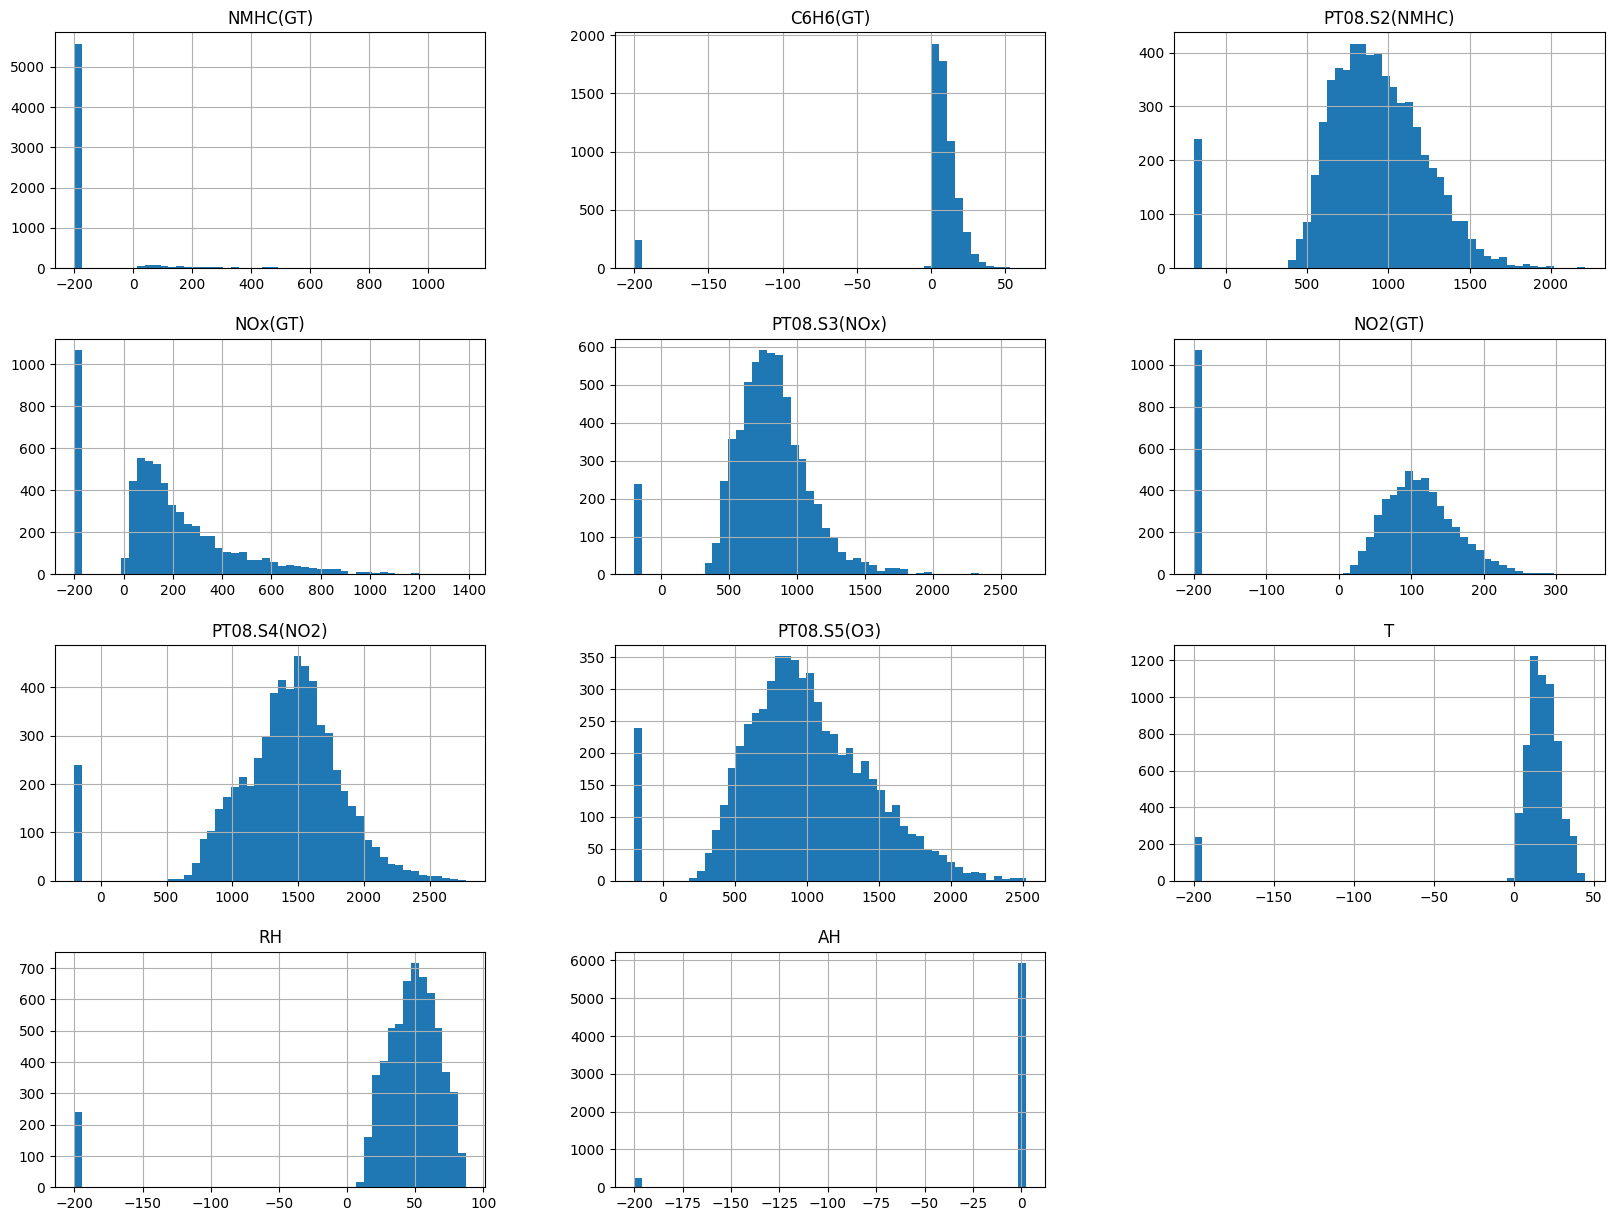

In [5]:
# Plot histograms for each feature in the dataset
features.hist(bins=50, figsize=(20,15))
plt.show()


We can see that many of the values in the column are less than 0. Intuitively, they should be greater than 0, so we choose to change them to 0.

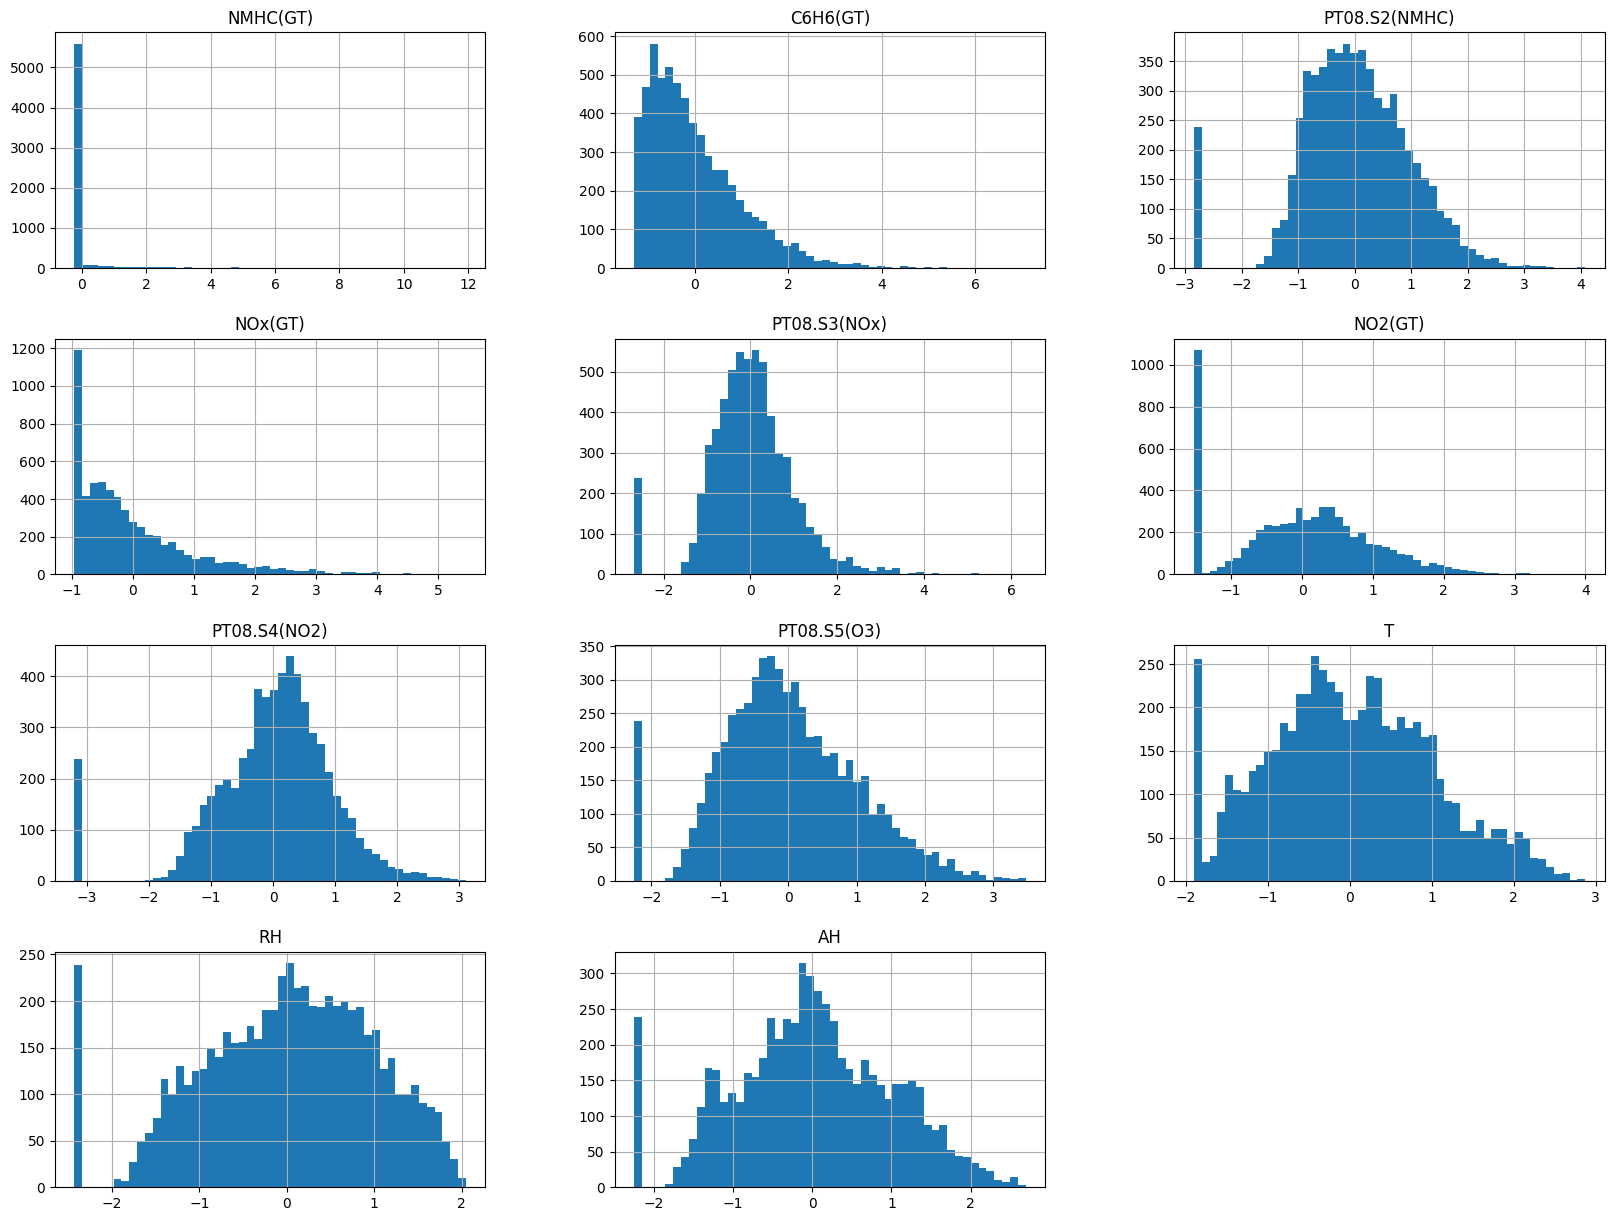

In [6]:
transformed_df = features.copy()
transformed_df[transformed_df < 0] = 0

scaler = StandardScaler()
scaled_values = scaler.fit_transform(transformed_df)
scaled_df = pd.DataFrame(scaled_values, index=transformed_df.index, columns=transformed_df.columns)

features_clean = scaled_df
# Plot histograms for each feature in the dataset
features_clean.hist(bins=50, figsize=(20,15))
plt.show()

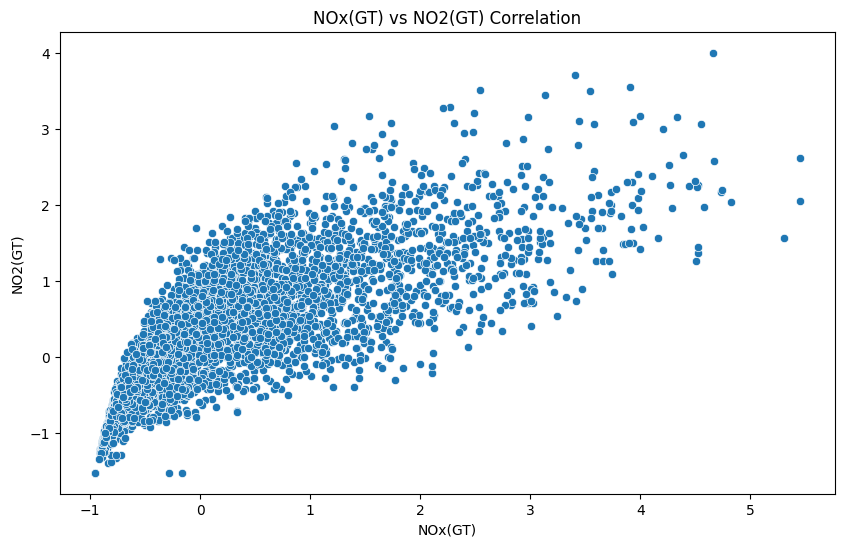

In [7]:
# Scatter plot for NOx(GT) vs NO2(GT)
plt.figure(figsize=(10,6))
sns.scatterplot(x='NOx(GT)', y='NO2(GT)', data=features_clean)
plt.title('NOx(GT) vs NO2(GT) Correlation')
plt.xlabel('NOx(GT)')
plt.ylabel('NO2(GT)')
plt.show()


As we can see from the picture above, we can infer that there is a certain relationship between these two properties.

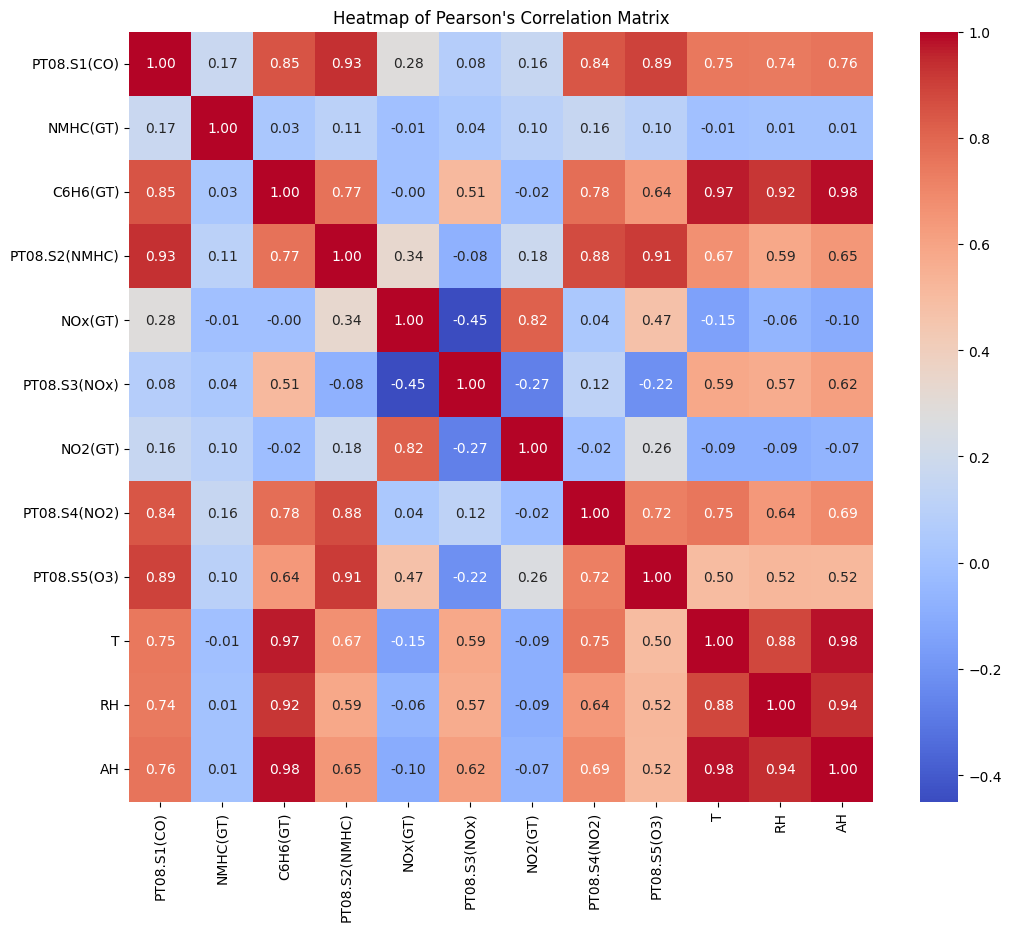

In [8]:
# Compute the Pearson's correlation matrix for variables 1-12
correlation_matrix = train_data.iloc[:, :12].corr()

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Pearson\'s Correlation Matrix')
plt.show()


We could know that:(1) There is a strong connection between each of the T, RH and AH attributes.C6H6 has a high correlation value with T, RH and AH.
(2)PT08.S1 doesn't seem to have a strong correlation with NHMC, NOx, PT08.S3, NO2.

### c. Linear Regression

In [9]:
X = features_clean.to_numpy()
y = label.to_numpy()

class LinearRegressionModel:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = 0

    def train(self, X, y):
        n_samples, n_features = X.shape 
        self.weights = np.zeros(n_features)

        for _ in range(self.epochs):
            y_pred = np.dot(X, self.weights) + self.bias

            dw = (np.dot(X.T, (y_pred - y))) / n_samples
            db = np.sum(y_pred - y) / n_samples

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias



### d. Logistic Regression Implementation

In [10]:
class LogisticRegressionModel:
    def __init__(self, learning_rate=0.03, epochs=1000):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = 0

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_cost(self, X, y):
        m = X.shape[0]
        y_hat = self.sigmoid(np.dot(X, self.weights) + self.bias)
        cost = -(1/m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        return cost

    def train(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros((n_features, 1))
        y = y.reshape(-1, 1)

        for i in range(self.epochs):
            y_hat = self.sigmoid(np.dot(X, self.weights) + self.bias)
            dw = (1/n_samples) * np.dot(X.T, (y_hat - y))
            db = (1/n_samples) * np.sum(y_hat - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        y_pred = self.sigmoid(np.dot(X, self.weights) + self.bias)
        return [1 if i > 0.5 else 0 for i in y_pred]
    
    def predict_proba(self, X):
        return self.sigmoid(np.dot(X, self.weights) + self.bias)
    
X = features_clean.to_numpy()
y = np.where(label > 1000, 1, 0)
lr_model = LogisticRegressionModel()
lr_model.train(X,y)
lr_model.weights,lr_model.bias

(array([[ 0.33491623],
        [ 0.72213438],
        [ 0.9822778 ],
        [ 0.15879256],
        [-0.75500524],
        [ 0.45869284],
        [ 0.71234825],
        [ 1.05069125],
        [ 0.02615632],
        [ 0.40779255],
        [ 0.02859173]]),
 1.2170446638160635)

### e

In [11]:
X = features_clean.to_numpy()
y = label.to_numpy()

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def kfold(X, y, n_splits=5, shuffle=True, random_state=None):
    if shuffle:
        np.random.seed(random_state)
        shuffled_indices = np.random.permutation(len(X))
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]
    else:
        X_shuffled = X 
        y_shuffled = y 
        
    fold_sizes = fold_sizes = len(X) // n_splits
    for fold in range(n_splits):
        start = fold * fold_sizes
        end = start + fold_sizes if fold != n_splits - 1 else len(X)
        X_test = X_shuffled[start:end]
        y_test = y_shuffled[start:end]
        X_train = np.concatenate([X_shuffled[:start], X_shuffled[end:]])
        y_train = np.concatenate([y_shuffled[:start], y_shuffled[end:]])
        yield X_train,y_train,X_test,y_test


rmse_scores = []


for X_train,y_train,X_test,y_test in kfold(X, y, n_splits=5, shuffle=True, random_state=0):
    model = LinearRegressionModel()
    model.train(X_train, y_train)
    predictions = model.predict(X_test)
    # calculate rsme
    score = rmse(predictions, y_test)
    rmse_scores.append(score)

average_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"RMSE scores across 5 folds: {rmse_scores}")
print(f"Average RMSE: {average_rmse}")
print(f"Standard Deviation of RMSE: {std_rmse}")


RMSE scores across 5 folds: [87.69529664292659, 84.53436047299085, 90.61334966028157, 90.36948279259703, 84.7693521925275]
Average RMSE: 87.5963683522647
Standard Deviation of RMSE: 2.614193540614256


We don't observe  a big change across different folds. With coefficient, we can find the item with the largest absolute value, which corresponds to the most informative feature.

### f

In [12]:
X = features_clean.to_numpy()
y = np.where(label > 1000, 1, 0)
def calculate_metrics(y_true, y_pred):
    
    tp = sum((y_true == 1) & (y_pred == 1))
    tn = sum((y_true == 0) & (y_pred == 0))
    fn = sum((y_true == 1) & (y_pred == 0))
    fp = sum((y_true == 0) & (y_pred == 1))

    accuracy = (tp + tn) / (tp + tn + fn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
 
for X_train,y_train,X_test,y_test in kfold(X, y, n_splits=5, shuffle=True, random_state=0):
    model = LogisticRegressionModel()
    model.train(X_train, y_train)
    predictions = model.predict(X_test)
    
    # calculate metrics
    accuracy, precision, recall, f1 = calculate_metrics(np.array(y_test),np.array(predictions))
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    
 
print(f"Average Accuracy: {np.mean(accuracy_scores)}, STD: {np.std(accuracy_scores)}")
print(f"Average Precision: {np.mean(precision_scores)}, STD: {np.std(precision_scores)}")
print(f"Average Recall: {np.mean(recall_scores)}, STD: {np.std(recall_scores)}")
print(f"Average F1 Score: {np.mean(f1_scores)}, STD: {np.std(f1_scores)}")


Average Accuracy: 0.9032902313722356, STD: 0.0020016586733168362
Average Precision: 0.928808587390472, STD: 0.006693401385244728
Average Recall: 0.9096233329354628, STD: 0.00360915107098876
Average F1 Score: 0.9190880864752644, STD: 0.0017228254490284458


The model behave similarly in different folds.

### g

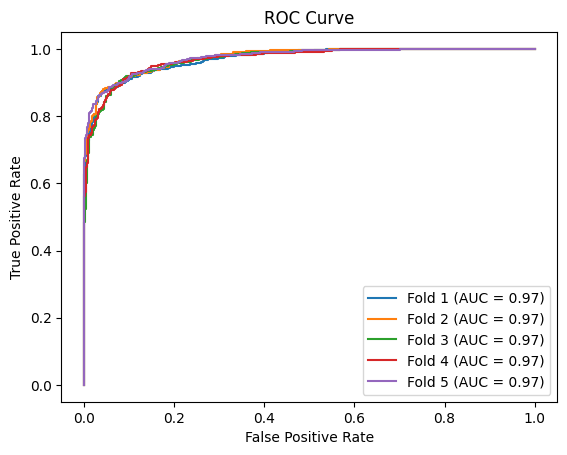

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc


X = features_clean.to_numpy()
y = np.where(label > 1000, 1, 0)

fig, ax = plt.subplots()
i = 0
for X_train,y_train,X_test,y_test in kfold(X, y, n_splits=5, shuffle=True, random_state=0):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
     
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute roc and plot
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')
    i+=1

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(loc='lower right')
plt.show()


The result is consistent with the results we obtained using the logistic regression model we implemented.

### h. Inference

In [14]:
#test_data_path = 'data_test.csv'
test_data_path = '/Users/ieon71/Desktop/CSCE633/hw1/data_test.csv'
test_data = pd.read_csv(test_data_path)

test_data = test_data.drop(columns='Unnamed: 0')
missing_values = test_data.isnull().sum()
print(missing_values)
test_data.dropna(inplace=True)

transformed_df = test_data.copy()
transformed_df[transformed_df < 0] = 0

scaled_values = scaler.transform(transformed_df)
scaled_df = pd.DataFrame(scaled_values, index=transformed_df.index, columns=transformed_df.columns)
X_test = scaled_df.to_numpy()

NMHC(GT)         37
C6H6(GT)         37
PT08.S2(NMHC)    37
NOx(GT)          37
PT08.S3(NOx)     37
NO2(GT)          37
PT08.S4(NO2)     37
PT08.S5(O3)      37
T                37
RH               37
AH               37
dtype: int64


In [15]:
X = features_clean.to_numpy()
y = label.to_numpy()
linear_model = LinearRegressionModel()
linear_model.train(X,y)
linear_predictions = linear_model.predict(X_test) 

y = np.where(label > 1000, 1, 0)
logistic_model = LogisticRegressionModel()
logistic_model.train(X,y)
logistic_predictions = logistic_model.predict(X_test)

# Save
predictions_df = pd.DataFrame({
    'pred_linear': linear_predictions.flatten(),  
    'pred_logistic': logistic_predictions
})

predictions_df.to_csv('predictions.csv', index=False)